# Problem loan prediction 2017 - Lending Club
## Testing kaggle model 1 (2007-2015)

https://www.kaggle.com/mina20/building-a-neural-net-to-predict-default/notebook

In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
import itertools
from sklearn import preprocessing
import matplotlib.pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import metric_spec
from tensorflow.contrib.learn.python.learn.estimators import _sklearn
from tensorflow.contrib.learn.python.learn.estimators import estimator
from tensorflow.contrib.learn.python.learn.estimators import model_fn
from tensorflow.python.framework import ops
from tensorflow.python.saved_model import loader
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.util import compat
tf.logging.set_verbosity(tf.logging.FATAL) 
df = pd.read_csv("../loan.csv", low_memory=False)

In [2]:
df['Default_Binary'] = int(0)
for index, value in df.loan_status.iteritems():
    if value == 'Default':
        df.set_value(index,'Default_Binary',int(1))
    if value == 'Charged Off':
        df.set_value(index, 'Default_Binary',int(1))
    if value == 'Late (31-120 days)':
        df.set_value(index, 'Default_Binary',int(1))    
    if value == 'Late (16-30 days)':
        df.set_value(index, 'Default_Binary',int(1))
    if value == 'Does not meet the credit policy. Status:Charged Off':
        df.set_value(index, 'Default_Binary',int(1)) 

In [3]:
df['Purpose_Cat'] = int(0) 
for index, value in df.purpose.iteritems():
    if value == 'debt_consolidation':
        df.set_value(index,'Purpose_Cat',int(1))
    if value == 'credit_card':
        df.set_value(index, 'Purpose_Cat',int(2))
    if value == 'home_improvement':
        df.set_value(index, 'Purpose_Cat',int(3))    
    if value == 'other':
        df.set_value(index, 'Purpose_Cat',int(4))    
    if value == 'major_purchase':
        df.set_value(index,'Purpose_Cat',int(5))
    if value == 'small_business':
        df.set_value(index, 'Purpose_Cat',int(6))
    if value == 'car':
        df.set_value(index, 'Purpose_Cat',int(7))    
    if value == 'medical':
        df.set_value(index, 'Purpose_Cat',int(8))   
    if value == 'moving':
        df.set_value(index, 'Purpose_Cat',int(9))    
    if value == 'vacation':
        df.set_value(index,'Purpose_Cat',int(10))
    if value == 'house':
        df.set_value(index, 'Purpose_Cat',int(11))
    if value == 'wedding':
        df.set_value(index, 'Purpose_Cat',int(12))    
    if value == 'renewable_energy':
        df.set_value(index, 'Purpose_Cat',int(13))     
    if value == 'educational':
        df.set_value(index, 'Purpose_Cat',int(14))  

In [4]:
x = np.array(df.int_rate.values).reshape(-1,1) 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['int_rate_scaled'] = pd.DataFrame(x_scaled)
print (df.int_rate_scaled[0:5])

0    0.225180
1    0.420363
2    0.449514
3    0.345163
4    0.311365
Name: int_rate_scaled, dtype: float64


In [5]:
x = np.array(df.funded_amnt.values).reshape(-1,1) 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['funded_amnt_scaled'] = pd.DataFrame(x_scaled)
print (df.funded_amnt_scaled[0:5])

0    0.130435
1    0.057971
2    0.055072
3    0.275362
4    0.072464
Name: funded_amnt_scaled, dtype: float64


In [6]:
df.shape

(887379, 78)

In [7]:
training_set = df[0:500000] # Train on first 500k rows
testing_set = df[500001:849999] # Test on next 350k rows
prediction_set = df[850000:] # Predict on final 37k rows

COLUMNS = ['Purpose_Cat','funded_amnt_scaled','int_rate_scaled','Default_Binary']          
FEATURES = ['Purpose_Cat','funded_amnt_scaled','int_rate_scaled']
LABEL = 'Default_Binary'

def input_fn(data_set):
    feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES} 
    labels = tf.constant(data_set[LABEL].values)
    return feature_cols, labels

In [8]:
feature_cols = [tf.contrib.layers.real_valued_column(k)
              for k in FEATURES]
#config = tf.contrib.learn.RunConfig(keep_checkpoint_max=1) ######## DO NOT DELETE
regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_cols, hidden_units=[10, 20, 10], ) 
regressor.fit(input_fn=lambda: input_fn(training_set), steps=251)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1224afc88>, 'hidden_units': [10, 20, 10], 'feature_columns': (_RealValuedColumn(column_name='Purpose_Cat', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='funded_amnt_scaled', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='int_rate_scaled', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)), 'optimizer': None, 'activation_fn': <function relu at 0x11e6b4378>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [9]:
# Score accuracy
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=10)
loss_score = ev["loss"]
print("Loss: {0:f}".format(loss_score))
loss_score

Loss: 0.025322


0.025322247

In [10]:
y = regressor.predict(input_fn=lambda: input_fn(prediction_set))
predictions = list(itertools.islice(y, 37379))

In [11]:
original = prediction_set.Default_Binary

In [12]:
print(type(predictions))

<class 'list'>


In [13]:
n_list = []
for i in predictions:
    a = i>0.5
    n_list.append(a)

In [14]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(original, n_list, labels=[0, 1])
cnf_matrix

array([[35312,     0],
       [ 2067,     0]])

In [15]:
import matplotlib.pyplot as pl
%matplotlib inline
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pl.cm.Blues):
    """ FROM SCIKIT LEARN DOCUMENTATION
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')

Confusion matrix, without normalization


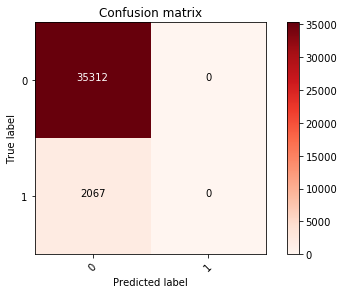

In [16]:
pl.figure()
plot_confusion_matrix(cnf_matrix, classes=prediction_set.Default_Binary.unique(),
                      cmap=pl.cm.Reds, normalize=False)

In [17]:
from sklearn.metrics import f1_score
f1_score(original, n_list, average='binary')

/Users/jpinzon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [18]:
(35312/(35312+2067))

0.9447015704004923

In [19]:
35312+2067

37379